Epoch 0: Loss = 0.631316
Epoch 20: Loss = 0.022116
Epoch 40: Loss = 0.000423
Epoch 60: Loss = 0.000165
Epoch 80: Loss = 0.000076


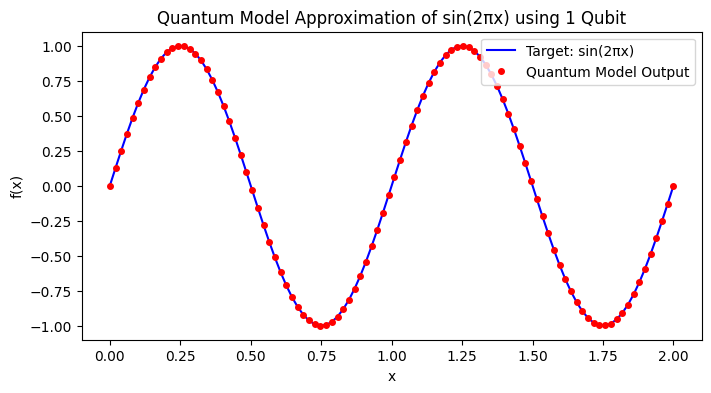

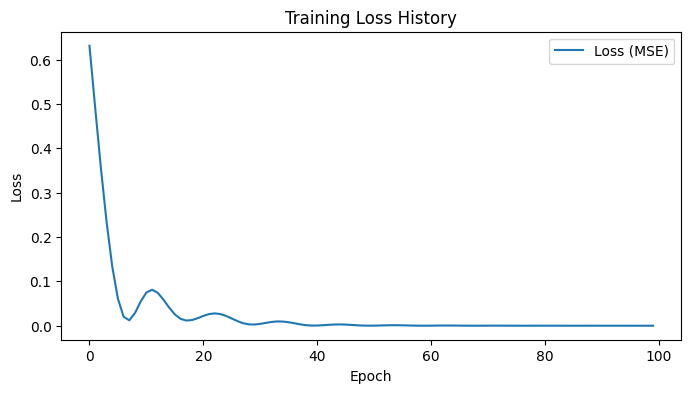

In [14]:
import pennylane as qml
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 1
# Build a quantum device using 3 qubits
dev = qml.device("default.qubit", wires=num_qubits)

# Define a quantum circuit using the PyTorch interface (interface="torch")
@qml.qnode(dev, interface="torch")
def circuit(x, weights, entanglement_weights):
    """
    Parameters:
      x: Input data (scalar)
      weights: A parameter tensor of shape (2, 3, 3),
               where each qubit in each layer uses three parameters to construct the qml.Rot gate.
               The first layer corresponds to weights[0] and the second layer to weights[1].
      entanglement_weights: A parameter tensor of shape (4,),
               used for two entanglement layers (each containing two parameters).
    
    Circuit Procedure:
      First layer: Apply a parameterized Rot gate (W(1)) on each qubit.
      First set of entanglement gates: Apply parameterized CRX gates on qubits 0→1 and 1→2 sequentially.
      Data encoding: Apply an RX(2πx) gate on each qubit to encode the input x.
      Second set of entanglement gates: Again apply parameterized CRX gates, on 0→1 and 1→2.
      Second layer: Apply a parameterized Rot gate (W(2)) on each qubit.
      Quantum measurement: Define a composite observable obs = (PauliZ(0)+PauliZ(1)+PauliZ(2))/3 and return its expectation value.
    """
    # First layer: W(1) using the qml.Rot gate
    for i in range(num_qubits):
        qml.Rot(weights[0, i, 0], weights[0, i, 1], weights[0, i, 2], wires=i)

    # First set of entanglement layers: using parameterized CRX gates
    # qml.CRX(entanglement_weights[0], wires=[0, 1])
    # qml.CRX(entanglement_weights[1], wires=[1, 2])

    # Data encoding: Apply RX(2πx) on each qubit to encode the input x
    for i in range(num_qubits):
        qml.RZ((2+i)*np.pi * x, wires=i)

    # Second set of entanglement layers: again using parameterized CRX gates
    # qml.CRX(entanglement_weights[2], wires=[0, 1])
    # qml.CRX(entanglement_weights[3], wires=[1, 2])

    # Second layer: W(2) using the qml.Rot gate
    for i in range(num_qubits):
        qml.Rot(weights[1, i, 0], weights[1, i, 1], weights[1, i, 2], wires=i)

    # Quantum measurement: Define a composite observable
    expectation_sum = 0
    for i in range(num_qubits):
        expectation_sum += qml.PauliZ(i)
    obs = expectation_sum / num_qubits
    return qml.expval(obs)

# Target function: sin(2πx)
def target_function(x):
    return np.sin(2 * np.pi * x)

# Generate training data: uniformly sample in the interval [0, 1]
num_points = 100
x_vals = np.linspace(0, 2, num_points)
y_vals = target_function(x_vals)

# Convert the training data to PyTorch tensors
x_train = torch.tensor(x_vals, dtype=torch.float32)
y_train = torch.tensor(y_vals, dtype=torch.float32)

# Initialize trainable parameters:
# weights: shape (2, 3, 3) corresponding to two layers, each with 3 qubits,
# where each qubit uses three rotation angles.
weights = torch.randn((2, 3, 3), dtype=torch.float32, requires_grad=True)
# entanglement_weights: shape (4,) corresponding to two entanglement segments each with two parameters
entanglement_weights = torch.randn((4,), dtype=torch.float32, requires_grad=True)

# Use the Adam optimizer to update parameters, note that both weights and entanglement_weights are passed in
optimizer = optim.Adam([weights, entanglement_weights], lr=0.1)

# Training process
num_epochs = 100
cost_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    # For each x value in the training data, call the quantum circuit to get the prediction
    predictions = torch.stack([circuit(x, weights, entanglement_weights) for x in x_train])
    # Compute the Mean Squared Error (MSE) loss
    loss = torch.mean((predictions - y_train)**2)
    # Backward propagation to update gradients
    loss.backward()
    optimizer.step()

    cost_history.append(loss.item())
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# After training, evaluate the model output on the training data
predictions = torch.stack([circuit(x, weights, entanglement_weights) for x in x_train]).detach().numpy()

# Plot the comparison between the target function and the quantum model output
plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_vals, label="Target: sin(2πx)", color="blue")
plt.plot(x_vals, predictions, 'o', label="Quantum Model Output", color="red", markersize=4)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Quantum Model Approximation of sin(2πx) using 1 Qubit")
plt.legend()
plt.show()

# Plot the training loss history over epochs
plt.figure(figsize=(8, 4))
plt.plot(cost_history, label="Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()
